# Flax & co. 101

Здесь представлен черновик для начала работы с
[`flax`](https://flax.readthedocs.io/en/latest/index.html),
[`optax`](https://optax.readthedocs.io/en/latest/) и
[`clu`](https://github.com/google/CommonLoopUtils), с помощью
которых мы будем строить и обучать нейронные сети. См. также *jax.ipynb* для
ознакомления с [`jax`](https://jax.readthedocs.io/en/latest/index.html).

In [2]:
import dataclasses
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flax
import jax
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from clu import metrics
from flax import linen as nn
from flax.training import train_state

tf.random.set_seed(0)
plt.style.use("ggplot")

## Что такое нейрон?

![Neuron](https://d2l.ai/_images/neuron.svg)

$\ldots \xrightarrow{дендриты}$
$\mathbf{x}$ $\xrightarrow{ядро}$ $\sigma(\mathbf{x}^T\mathbf{w} + b)$
$\xrightarrow{аксон}$ $\mathbf{y}$
$\xrightarrow{терминаль}$ $\ldots$
🥴

## Постановка задачи

$\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_n] \in \mathbb{R}^{n \times m \times k}$ $-$ чёрно-белые изображения,
$\mathbf{y} = [y_1, \ldots, y_n]^T \in \{0, 1, \ldots, 9\}^n$ $-$ метки изображений.

Необходимо обучить сеть $a(\mathbf{x}; \mathbf{w})$, которая предсказывает метку $y$ при заданном изображении $\mathbf{x}$.

Чтобы решить эту задачу, попробуем адаптировать понятие нейрона, создав линейный классификатор с функцией активации,
возвращаюей вероятности принадлежности изображения к меткам:
$$
\begin{split}\begin{aligned}
    \mathbf{o} &= \mathbf{x}^T \mathbf{w} + b, \\
    \hat{y} = a(\mathbf{x}; \mathbf{w}) &= \mathrm{softmax}(\mathbf{o}).
\end{aligned}\end{split}
$$
Как найти оптимальное значение параметров $\mathbf{w}$? Вспомним секцию *autodiff*
черновика *jax.ipynb*, где мы учились минимизировать заданную функцию потерь. В
качестве функции потерь возьмём *cross-entropy loss*.

Начнём 🙃

In [3]:
@dataclasses.dataclass
class Config:
    """Датакласс с гиперпараметрами, а также дополнительными параметрами объектов ниже.
    """
    num_epochs: int
    batch_size: int = 32
    learning_rate: float = 0.1
    buffer_size: int = 1024
    verbose: int = 10

In [4]:
def get_datasets(config):
    """По указанному конфигу `config` выгружает пары датасетов Fashion MNIST.

    Выполняет нормализацию датасетов, делит по батчам, перемешивает,
    а также повторяет указанное в конфиге количество эпох обучающую выборку.
    """
    # Загрузка обеих сетов
    train_ds = tfds.load("fashion_mnist", split="train")
    test_ds = tfds.load("fashion_mnist", split="test")
    # Нормализация обеих сетов
    train_ds = train_ds.map(
        lambda sample: {
            "image": tf.cast(sample["image"], tf.float32) / 255.,
            "label": sample["label"],
        },
    )
    test_ds = test_ds.map(
        lambda sample: {
            "image": tf.cast(sample["image"], tf.float32) / 255.,
            "label": sample["label"],
        },
    )
    # Повтор `config.num_epochs` раз обучающей выборки и перемешивание
    train_ds = train_ds.repeat(config.num_epochs).shuffle(config.buffer_size)
    test_ds = test_ds.shuffle(config.buffer_size)
    # Разбиение обоих сетов по батчам
    train_ds = train_ds.batch(config.batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.batch(config.batch_size, drop_remainder=True).prefetch(1)
    # Возвращение обоих сетов
    return train_ds, test_ds

In [5]:
config = Config(num_epochs=1, batch_size=1)
train_ds, test_ds = get_datasets(config)
batch = next(train_ds.as_numpy_iterator())
batch["image"].shape, batch["label"]

((1, 28, 28, 1), array([5]))

In [6]:
class SoftmaxRegression(flax.linen.Module):
    """Softmax-регрессия для классификации одежды из FashionMNIST."""
    
    @flax.linen.compact
    def __call__(self, x):
        """Из матриц с картинками в векторы и линейное преобразование.

        Note:
            softmax будет применён при досчёте потерь.
        """
        x = x.reshape((x.shape[0], -1))
        x = flax.linen.Dense(10)(x)
        return x

net = SoftmaxRegression()
key = jax.random.key(0)
# Информация о слоях, параметрах, IO
print(net.tabulate(key, batch["image"]))


                           SoftmaxRegression Summary                            
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs          ┃ outputs       ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ SoftmaxRegress… │ float32[1,28,2… │ float32[1,10] │                │
├─────────┼─────────────────┼─────────────────┼───────────────┼────────────────┤
│ Dense_0 │ Dense           │ float32[1,784]  │ float32[1,10] │ bias:          │
│         │                 │                 │               │ float32[10]    │
│         │                 │                 │               │ kernel:        │
│         │                 │                 │               │ float32[784,1… │
│         │                 │                 │               │                │
│         │                 │                 │               │ 7,850 (31.4    │
│         │                

In [7]:
@flax.struct.dataclass
class Metrics(metrics.Collection):
    """Коллекция метрик: доля верных ответов и значение функции потерь."""
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output("loss")

In [8]:
class SoftmaxTrainState(train_state.TrainState):
    """Помимо номера итерации, параметров, etc., мониторинг (коллекции) метрик."""
    metrics: Metrics

def create_train_state(key, net, config, dummy_input):
    """Инициализация и создание `SoftmaxTrainState`."""
    # Инициализация параметров модели
    params = net.init(key, dummy_input)["params"]
    # Инициализация SGD-оптимизатора
    tx = optax.sgd(config.learning_rate)

    return SoftmaxTrainState.create(
        apply_fn=net.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty(),
    )

net = SoftmaxRegression()
state = create_train_state(key, net, config, batch["image"])
state.params["Dense_0"]["bias"], state.metrics.accuracy, state.step

(Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 Accuracy(total=Array(0., dtype=float32), count=Array(0, dtype=int32)),
 0)

In [9]:
@jax.jit
def train_step(state, batch):
    """Одна итерация обучения модели.

    See also:
        Stateful Computations in JAX. [URL](https://jax.readthedocs.io/en/latest/jax-101/07-state.html)
    """
    # Функция для подсчёта softmax cross-entropy loss
    def loss_fn(params):
        logits = state.apply_fn({"params": params}, batch["image"])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits,
            labels=batch["label"],
        ).mean()
        return loss
    # Градиент функции
    grad_loss_fn = jax.grad(loss_fn)
    grads = grad_loss_fn(state.params)
    # Обновление параметров
    state = state.apply_gradients(grads=grads)
    # Обновлённый `state`
    return state

In [10]:
@jax.jit
def compute_metrics(state, batch):
    """Подсчёт метрик по `batch` и обновление `state`."""
    logits = state.apply_fn({"params": state.params}, batch["image"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits,
        labels=batch["label"],
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits,
        labels=batch["label"],
        loss=loss,
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [11]:
key = jax.random.key(0)
config = Config(num_epochs=50, learning_rate=0.01)
train_ds, test_ds = get_datasets(config)
net = SoftmaxRegression()
state = create_train_state(key, net, config, batch["image"])

In [12]:
def train_1(*, train_ds, test_ds, state, config):
    """Обучение и валидация модели.

    Версия №1: без раннего останова и разбиения обучающей выборки на train-val.
    """
    # Возвращаем значения метрик на каждой эпохе.
    history = {
        "train_accuracy": [],
        "train_loss": [],
        "test_accuracy": [],
        "test_loss": [],
    }
    # Количество эпох.
    num_steps_per_epoch = train_ds.cardinality().numpy() // config.num_epochs

    # Проходим по обучающей выборке:
    for step, batch in enumerate(train_ds.as_numpy_iterator(), start=1):
        # Обновляем `state`.
        state = train_step(state, batch)
        # Считаем метрики.
        state = compute_metrics(state, batch)

        # Под конец эпохи считаем и сохраняем метрики на тесте:
        if step % num_steps_per_epoch == 0:
            for metric, value in state.metrics.compute().items():
                history[f"train_{metric}"].append(value)
            state = state.replace(metrics=state.metrics.empty())

            test_state = state
            for test_batch in test_ds.as_numpy_iterator():
                test_state = compute_metrics(test_state, test_batch)
    
            for metric,value in test_state.metrics.compute().items():
                history[f"test_{metric}"].append(value)

            epoch = step // num_steps_per_epoch
            if config.verbose and epoch % config.verbose == 0:
                print(
                    f"epoch: {epoch}\n  "
                    f"train loss: {history['train_loss'][-1]:.3f}, "
                    f"train acc: {history['train_accuracy'][-1] * 100:.2f}%, "
                    f"test loss: {history['test_loss'][-1]:.3f}, "
                    f"test acc: {history['test_accuracy'][-1] * 100:.2f}%"
                )

    return history

In [13]:
history = train_1(train_ds=train_ds, test_ds=test_ds, state=state, config=config)

epoch: 10
  train loss: 0.443, train acc: 85.22%, test loss: 0.484, test acc: 83.42%
epoch: 20
  train loss: 0.415, train acc: 86.04%, test loss: 0.464, test acc: 83.82%
epoch: 30
  train loss: 0.401, train acc: 86.42%, test loss: 0.451, test acc: 84.27%
epoch: 40
  train loss: 0.392, train acc: 86.59%, test loss: 0.450, test acc: 84.30%
epoch: 50
  train loss: 0.387, train acc: 86.92%, test loss: 0.443, test acc: 84.50%


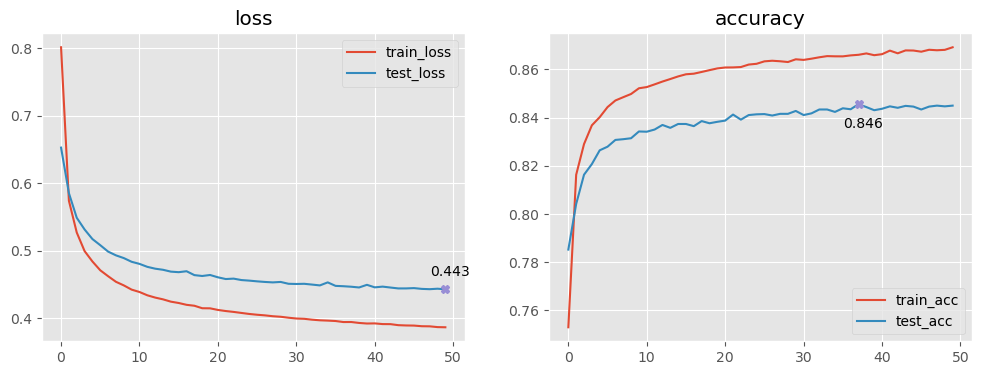

In [14]:
def plot_history(history):
    """Чертёж графиков для loss и accuracy."""
    # По одному чарту для loss и accuracy
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Для каждого чарта рисуем метрики на обучении и валидации
    for prefix in ("train", "test"):
        axes[0].plot(history[f"{prefix}_loss"], label=f"{prefix}_loss")
        axes[1].plot(history[f"{prefix}_accuracy"], label=f"{prefix}_acc")
    # Различные надписи
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title("loss")
    axes[1].set_title("accuracy")
    # Лучшее значение потерь
    best_loss = np.min(history["test_loss"])
    best_loss_idx = np.argmin(history["test_loss"])
    axes[0].plot(best_loss_idx, best_loss, "X")
    axes[0].text(best_loss_idx - 2, best_loss + 0.02, f"{best_loss:.3f}")
    # Лучшее значение accuracy
    best_acc = np.max(history["test_accuracy"])
    best_acc_idx = np.argmax(history["test_accuracy"])
    axes[1].plot(best_acc_idx, best_acc, "X")
    axes[1].text(best_acc_idx - 2, best_acc - 0.01, f"{best_acc:.3f}")
    plt.show()

plot_history(history)

In [15]:
@jax.jit
def pred_step(state, batch):
    """Предсказание наиболее вероятного класса."""
    logits = state.apply_fn({"params": state.params}, test_batch["image"])
    return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred_batch = pred_step(state, test_batch)

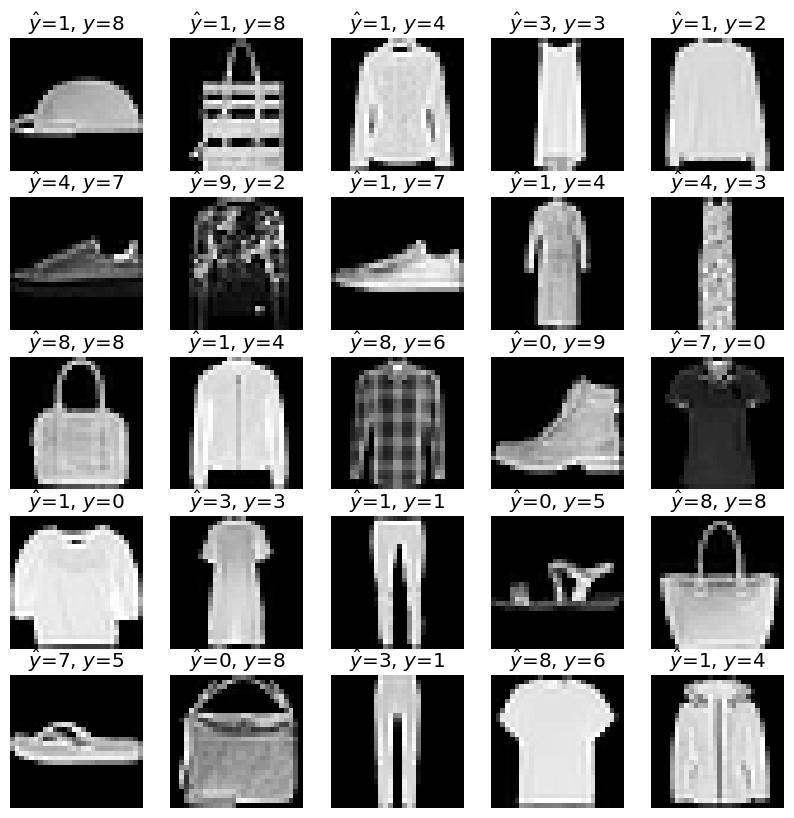

In [16]:
def plot_predictions(true_batch, pred_batch):
    """Рисуем картинки с предсказанными и настоящими метками."""
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(true_batch["image"][i, ..., 0], cmap="gray")
        ax.set_title("$\hat{y}$=%d, $y$=%d" % (pred_batch[i], true_batch['label'][i]))
        ax.axis("off")

plot_predictions(test_batch, pred_batch)

**_Задания_**:
1. Попробуйте использовать другой метод оптимизации, какой посчитаете интересным (см. `optax`). Нужно ли добавлять новые гиперпараметры?
2. Что, если количество эпох было подобрано больше, чем нужно? Видно ли это на графике? Как насчёт *раннего останова*? (см. `flax.training.early_stopping`)
3. Есть ли дизбаланс классов? Может, обуви намного больше и мы постоянно лениво предсказываем обувь, чтобы соответствующим образом получить высокую долю верных ответов? Если да, как исправить? (см. `clu.metrics`)

In [17]:
class NotLeNet1(nn.Module):
    """Что-то похожее на архитектуру LeNet-5.

    References:
        LeCun et al. (1989). Backpropagation applied to handwritten zip code
        recognition. Neural Computation, 1(4), 541–551.
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(32, kernel_size=(3, 3))(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(64, kernel_size=(3, 3))(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(256)(x)
        x = nn.tanh(x)
        x = nn.Dense(10)(x)
        return x

In [18]:
key, subkey = jax.random.split(key)
net = NotLeNet1()
print(net.tabulate(subkey, batch["image"]))


                               NotLeNet1 Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs           ┃ outputs          ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ NotLeNet1 │ float32[1,28,28… │ float32[1,10]    │                  │
├─────────┼───────────┼──────────────────┼──────────────────┼──────────────────┤
│ Conv_0  │ Conv      │ float32[1,28,28… │ float32[1,28,28… │ bias:            │
│         │           │                  │                  │ float32[32]      │
│         │           │                  │                  │ kernel:          │
│         │           │                  │                  │ float32[3,3,1,3… │
│         │           │                  │                  │                  │
│         │           │                  │                  │ 320 (1.3 KB)     │
├─────────┼───────────┼────

In [19]:
key, subkey = jax.random.split(key)
config = Config(num_epochs=50, learning_rate=0.02, verbose=5)
train_ds, test_ds = get_datasets(config)
state = create_train_state(subkey, net, config, batch["image"])
history = train_1(train_ds=train_ds, test_ds=test_ds, state=state, config=config)

epoch: 5
  train loss: 0.462, train acc: 83.60%, test loss: 0.531, test acc: 80.31%
epoch: 10
  train loss: 0.374, train acc: 87.25%, test loss: 0.495, test acc: 82.04%
epoch: 15
  train loss: 0.330, train acc: 88.72%, test loss: 0.420, test acc: 84.68%
epoch: 20
  train loss: 0.304, train acc: 89.65%, test loss: 0.395, test acc: 85.73%
epoch: 25
  train loss: 0.283, train acc: 90.33%, test loss: 0.390, test acc: 86.04%
epoch: 30
  train loss: 0.267, train acc: 90.85%, test loss: 0.376, test acc: 86.33%
epoch: 35
  train loss: 0.253, train acc: 91.42%, test loss: 0.361, test acc: 86.94%
epoch: 40
  train loss: 0.242, train acc: 91.71%, test loss: 0.346, test acc: 87.66%
epoch: 45
  train loss: 0.232, train acc: 92.08%, test loss: 0.338, test acc: 87.64%
epoch: 50
  train loss: 0.222, train acc: 92.39%, test loss: 0.334, test acc: 88.01%


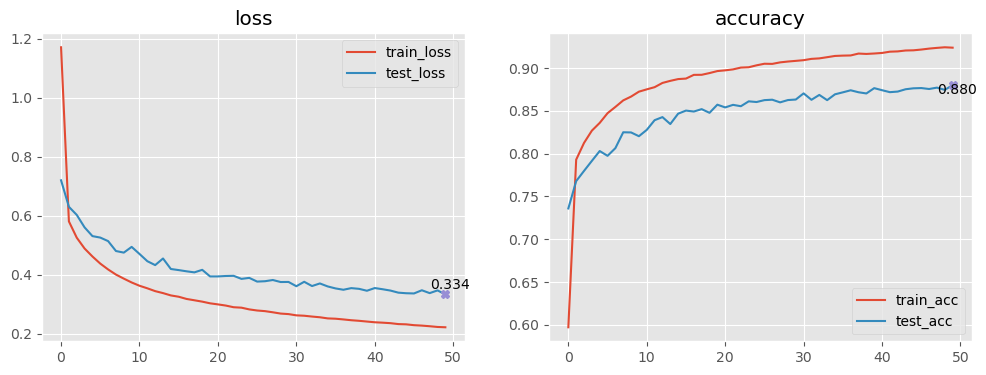

In [20]:
plot_history(history)

**_Задания_**:
1. Последующие улучшения CNN были связаны с использованием функции активации RELU и max-pooling. Попробуйте изменить `NoLeNet1` и посмотреть, улучшатся ли результаты.
2. Как бы Вы реализовали добавление слоя dropout? а batchnorm?